## Imports

In [ ]:
import numpy as np
import re
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb")
df = dataset["train"].to_pandas()
print("Número de ejemplos del dataset:", len(df))

In [ ]:
df.head(5)

In [ ]:
print(df.text[270][:46])
print('neg' if df.label[270] == 0 else 'pos'  )

In [ ]:
print(df.text[14500][103:174])
print('neg' if df.label[14500] == 0 else 'pos'  )

# Preprocesado de texto

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]*>', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenization and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Vectorizing


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_test):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit(X_train)
    x_train_tfidf = tfidf_matrix.transform(X_train)
    x_test_tfidf = tfidf_matrix.transform(X_test)
    return x_train_tfidf, x_test_tfidf

In [46]:
from sentence_transformers import SentenceTransformer

def embeddings_features(X_train, X_test):
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    X_train_embeddings = model.encode(X_train)
    X_test_embeddings = model.encode(X_test)
    return np.array(X_train_embeddings), np.array(X_test_embeddings)

In [ ]:
from sklearn.model_selection import train_test_split

X_preprocessed = [preprocess_text(text) for text in df.text]

train_test_sets = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, df.label, test_size=0.05, train_size=0.2, random_state=i, shuffle=True)
    train_test_sets.append((X_train, X_test, y_train, y_test))

# Comparador clasificadores

In [53]:
import tensorflow.keras as keras
from keras.layers import Dropout, Dense, Reshape, LSTM, Input, Conv1D, Input, Dense,MaxPooling1D, Flatten, Dropout
import numpy as np

modelNN = keras.Sequential([

    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide
])
modelRNN = keras.Sequential([
    #Input(shape=(32,24)),
    Reshape((32,24)),
    LSTM(128, return_sequences=True,activation='relu'),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
])

modelCNN = keras.Sequential([
    Reshape((32,24)),
    Conv1D(32, 5, activation='relu'),
    Dropout(0.2),
    MaxPooling1D(2),
    Conv1D(32, 5, activation='relu'),
    Dropout(0.2),
    MaxPooling1D(2),
    Flatten(),

    Dense(20, activation='relu'),

    Dense(1, activation='sigmoid')
])
modelNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelRNN.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
modelCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def reshape(X):
    return X.reshape(X.shape[0], 32, 24)

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in np.arange(0, 1, 0.01):
        score = accuracy_score(y_true, (y_proba > threshold).astype(int))
        if score > best_score:
            best_threshold = threshold
            best_score = score
    return best_threshold, best_score


def train_nn(model, X_train, y_train, X_test, y_test):
    # Train the model with the validation callback
    model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],verbose=0)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Search for the optimal threshold
    threshold, acc = threshold_search(y_test, y_pred)
    
    # Define the custom rounding function


    custom_round = np.vectorize(lambda n: int(n) if n - int(n) < threshold else int(n) + 1)    
    # Print the classification report
    return([custom_round(pred) for pred in y_pred])

In [ ]:
#modelCNN.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)],verbose=1)


In [54]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



def plot_histograms(all_seeds_results):
    metrics = ['precision', 'recall', 'fscore']
    num_classifiers = len(all_seeds_results)
    num_metrics = len(metrics)
    bar_width = 0.2  # Ancho de cada barra
    index = np.arange(num_classifiers)  # Índices para cada grupo de barras

    # Colores distintivos para las barras
    colors = plt.cm.tab10(np.linspace(0, 1, num_metrics))

    plt.figure(figsize=(10, 6))

    for i, metric in enumerate(metrics):
        means = [np.mean(data[metric]) for data in all_seeds_results.values()]
        stds = [np.std(data[metric]) for data in all_seeds_results.values()]

        # Desplazar los índices para cada métrica
        shift = bar_width * (i - (num_metrics - 1) / 2)

        plt.bar(index + shift, means, bar_width, label=metric.capitalize(), color=colors[i])

        # Añadir barras de error
        plt.errorbar(index + shift, means, yerr=stds, fmt='none', color='black', capsize=5)

    plt.xlabel('Classifier')
    plt.ylabel('Mean Value')
    plt.title('Mean Metrics by Classifier')
    plt.xticks(index, all_seeds_results.keys(), rotation=45)
    plt.legend()
    plt.ylim(0.7, None)  # Límites del eje y a partir de 0.7
    plt.tight_layout()
    plt.show()



def compare_classifiers(X_train, X_test, y_train, y_test,method='tfidf'):
    classifiers_tfid = [
        ('Logisti Regression', LogisticRegression(random_state=42)),
        ('Gaussian Naive Bayes', MultinomialNB()),
        ('Rando Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('KNN', KNeighborsClassifier(n_neighbors=5)),
        #('Neural Network', model),
    ]
    classifiers_embeddings =[
        ('RNN', modelRNN),
        ('CNN', modelCNN),
        ('NN', modelNN),
        ('Logisti Regression', LogisticRegression(random_state=42)),
        ('Gaussian Naive Bayes', GaussianNB()),
        ('Rando Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ]
    if method == 'tfidf':
        classifiers = classifiers_tfid
    else:
        classifiers = classifiers_embeddings
    results = {}
    for name, clf in classifiers:
        if name == 'RNN' or name == 'CNN' or name == 'NN':
            if method == 'tfidf':
                continue
            else:
                y_pred = train_nn(clf,X_train, y_train, X_test, y_test)

        else:    
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
        
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        
        if name not in results:
            results[name] = {'precision': [], 'recall': [], 'fscore': []}
        results[name]['precision'].append(precision)
        results[name]['recall'].append(recall)
        results[name]['fscore'].append(fscore)
    return results

# Initialize a dictionary to hold all results
def compare_seeds(train_test_sets, method='tfidf'):
    all_seeds_results = {}

    for i, (X_train, X_test, y_train, y_test) in enumerate(train_test_sets):
        print(f"---- Random Seed: {i} ----")
        if method == 'tfidf':
            X_train, X_test = tfidf_features(X_train, X_test)
        else:
            X_train, X_test = embeddings_features(X_train, X_test)
        seed_results = compare_classifiers(X_train, X_test, y_train, y_test,method)

        for clf_name, metrics in seed_results.items():
            if clf_name not in all_seeds_results:
                all_seeds_results[clf_name] = {'precision': [], 'recall': [], 'fscore': []}
            
                
            # Accumulate results
            for metric_name, metric_values in metrics.items():
                all_seeds_results[clf_name][metric_name] += metric_values

        # Compute and print averages
    for clf_name, metrics in all_seeds_results.items():
        print(f'----- {clf_name} Average Metrics -----')
        for metric_name, metric_values in metrics.items():
            print(f'{metric_name.capitalize()} Avg: {np.mean(metric_values):.4f}')
        print('\n')
    plot_histograms(all_seeds_results)
    return all_seeds_results


---- Random Seed: 0 ----
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


---- Random Seed: 1 ----
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


---- Random Seed: 2 ----
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


---- Random Seed: 3 ----
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


---- Random Seed: 4 ----
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


C:\Users\Diegopolis\AppData\Local\Temp\ipykernel_18908\2642748061.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  custom_round = lambda n: int(n) if n - int(n) < threshold else int(n) + 1


----- RNN Average Metrics -----
Precision Avg: 0.8520
Recall Avg: 0.8510
Fscore Avg: 0.8510


----- CNN Average Metrics -----
Precision Avg: 0.8716
Recall Avg: 0.8715
Fscore Avg: 0.8715


----- NN Average Metrics -----
Precision Avg: 0.8660
Recall Avg: 0.8651
Fscore Avg: 0.8651


----- Logisti Regression Average Metrics -----
Precision Avg: 0.8519
Recall Avg: 0.8512
Fscore Avg: 0.8512


----- Gaussian Naive Bayes Average Metrics -----
Precision Avg: 0.7846
Recall Avg: 0.7827
Fscore Avg: 0.7826


----- Rando Forest Average Metrics -----
Precision Avg: 0.8167
Recall Avg: 0.8152
Fscore Avg: 0.8151


----- KNN Average Metrics -----
Precision Avg: 0.7864
Recall Avg: 0.7859
Fscore Avg: 0.7858




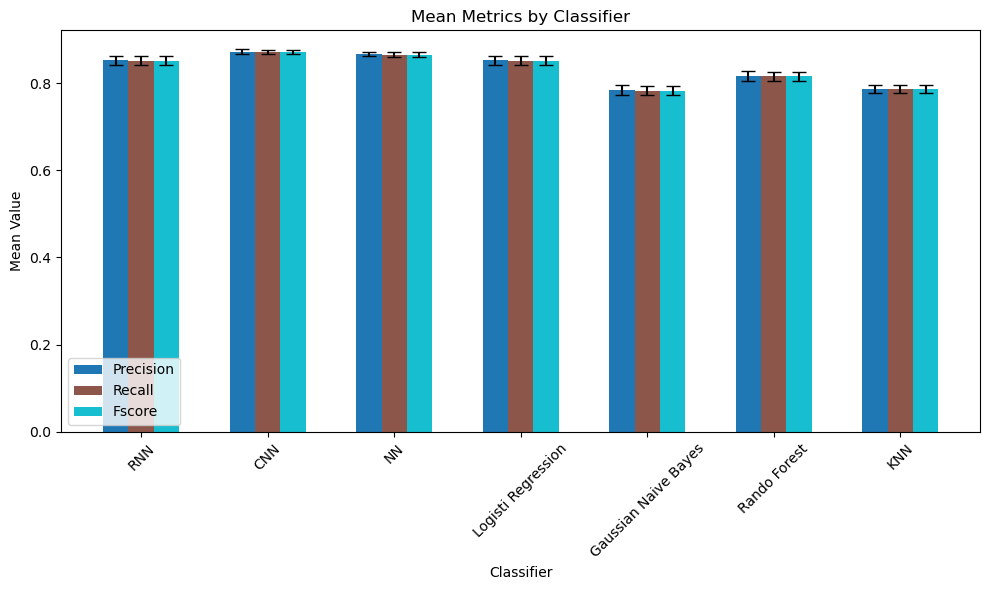

In [50]:
all_seeeds_results = compare_seeds(train_test_sets,'embeddings')

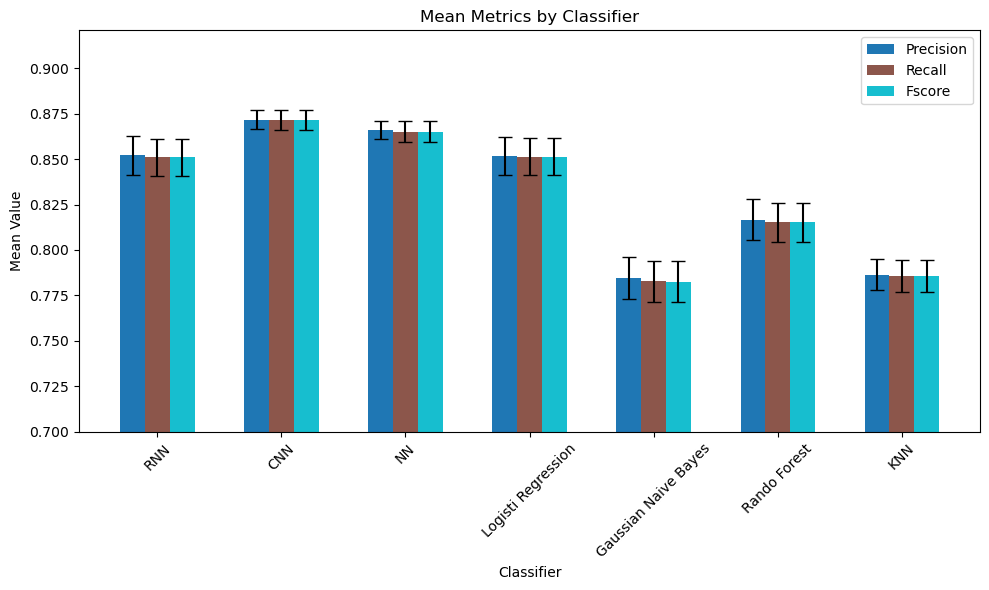

In [52]:
plot_histograms(all_seeeds_results)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_sets[0]
#X_train, X_test = embeddings_features(X_train, X_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_sets[0]
X_train, X_test = embeddings_features(X_train, X_test)
X_train = X_train.reshape(5000,32,24)
X_test = X_test.reshape(1250,32,24)

In [ ]:
y_pred = train_nn(model,X_train, y_train, X_test, y_test)
precision_recall_fscore_support(y_test, y_pred, average='weighted')

In [ ]:
from keras.layers import Conv1D, Input, Dense,MaxPooling1D, Flatten, Dropout
X_train =X_train.reshape(5000,32,24)
X_test = X_test.reshape(1250,32,24)
model = keras.Sequential([
    Input(shape=(32,24)),
    Conv1D(32, 5, activation='relu'),
    Dropout(0.2),
    MaxPooling1D(2),
    Conv1D(32, 5, activation='relu'),
    Dropout(0.2),
    MaxPooling1D(2),
    Flatten(),

    Dense(20, activation='relu'),

    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],verbose=1)
